In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import missingno as msno
import seaborn as sns
import numpy as np

In [3]:
Data=pd.read_csv('/content/music_genre.csv')


In [82]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Columns: 127 entries, instance_id to column_name_108
dtypes: float64(12), object(6), uint8(109)
memory usage: 12.4+ MB


In [5]:
Data["tempo"]=Data["tempo"].replace('?',np.nan)
Data["tempo"]=Data["tempo"].astype(float)

# Update music_genre column
#Data = Data.drop(Data[Data['artist_name'] == 'empty_field'].index)
Data.groupby(['music_genre'])['tempo'].mean()

Data['tempo']=Data['tempo'].fillna(Data.groupby(['music_genre'])['tempo'].transform('mean'))

In [6]:
Data = Data.dropna()


In [7]:
grouped_df = Data.groupby([ 'music_genre','artist_name']).size().reset_index(name='count')
pivot_table = pd.pivot_table(grouped_df, values='count', index='artist_name', columns='music_genre', fill_value=0)
pivot_table

music_genre,Alternative,Anime,Blues,Classical,Country,Electronic,Hip-Hop,Jazz,Rap,Rock
artist_name,,,,,,,,,,
!!!,1,0,0,0,0,21,0,0,0,0
"""Weird Al"" Yankovic",0,0,0,0,0,0,0,0,0,1
$NOT,0,0,0,0,0,0,3,0,0,0
$tupid Young,0,0,0,0,0,0,0,0,1,0
$uicideBoy$,0,0,0,0,0,0,51,0,41,0
...,...,...,...,...,...,...,...,...,...,...
棗坂シキ(CV.平川大輔),0,1,0,0,0,0,0,0,0,0
楚神ウリエ(CV.近藤隆),0,2,0,0,0,0,0,0,0,0
立華リツカ(CV.茜屋日海夏),0,1,0,0,0,0,0,0,0,0


In [8]:
a=pd.DataFrame(pivot_table)

In [70]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Columns: 127 entries, instance_id to column_name_108
dtypes: float64(12), object(6), uint8(109)
memory usage: 12.4+ MB


In [9]:
from scipy.sparse import csr_matrix

# Convert your data to a sparse matrix
sparse_matrix = csr_matrix(pivot_table)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
cos_sim_matrix = cosine_similarity(sparse_matrix)

# Assuming your data is stored in a pandas dataframe called 'df'
# Run kmeans with k=103
kmeans = KMeans(n_clusters=109, random_state=42)
cluster_labels = kmeans.fit_predict(cos_sim_matrix)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
diction={}
for i in range(6863):
  diction[a.index[i]]=cluster_labels[i]

In [12]:
Data['cluster'] = Data['artist_name'].replace(diction)
dummies = pd.get_dummies(Data['cluster'], prefix='column_name')

# concatenate dummies with original dataframe
Data = pd.concat([Data, dummies], axis=1)
Data = Data.drop('cluster', axis=1)

In [134]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, ClassifierMixin
class MyModel(BaseEstimator, ClassifierMixin):
    def __init__(self,C=0.1,penalty='l2',solver='lbfgs'):
        self.C = C
        self.penalty=penalty
        self.solver=solver

     #   self.clf = LogisticRegression()
        self.oversampler = SMOTE()
        self.models = [LogisticRegression(C=C,solver=solver,penalty=penalty,max_iter=1000) for _ in range(10)]
    def fit(self, X, y_bin):
        
       # mlb = MultiLabelBinarizer()
        #y_bin = mlb.fit_transform(y)
        for i, model in enumerate(self.models):
            X_resampled, y_resampled = self.oversampler.fit_resample(X, y_bin[:, i])
            self.models[i]=model.fit(X_resampled, y_resampled)
            
    def predict(self, X):
        #print(len(self.models))
        y_pred1 = np.zeros((X.shape[0], len(self.models)))
        y_pred2 = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            a = model.predict_proba(X)
            y_pred1[:, i] = a[:, 0]
            y_pred2[:, i] = a[:, 1]
           # print(y_pred2.shape)
        
        new_arr = np.zeros_like(y_pred2)

        new_arr[np.arange(y_pred2.shape[0]), np.argmax(y_pred2, axis=1)] = int(1)
        return new_arr    
    def score(self, X, y, sample_weight=None):
       # y = mlb.fit_transform(y)
      #  print("score",y.shape)
        y_pred = self.predict(X)
     #   print("score 0",y_pred.shape)
       # return f1_score(y, y_pred, average='weighted', sample_weight=sample_weight)
        return accuracy_score(y,y_pred)

In [136]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV

ss = StandardScaler()
my_model = MyModel()

param_grid = {'C': [0.1,0.3,0.5, 1, 10]}
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1,0.5, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

#pipeline = Pipeline(('estimator', my_model])
X_train, X_test, y_train, y_test = train_test_split(ss.fit_transform(Data.select_dtypes(exclude=['object']).values), Data['music_genre'].apply(lambda x: [x]), test_size=0.2, random_state=42)
grid_search = GridSearchCV(my_model, param_grid=param_grid, cv=5)
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

KeyboardInterrupt: ignored

In [138]:
grid_search

GridSearchCV(cv=5, estimator=MyModel(),
             param_grid={'C': [0.1, 0.5, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

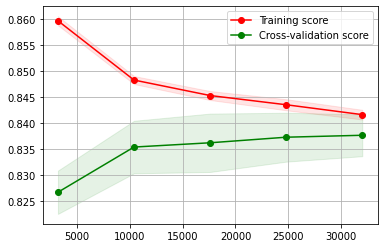

In [139]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

my_model = MyModel()

plot_learning_curve(my_model, X_train, y_train,cv=5,n_jobs=4)


In [162]:
X_train, X_test, y_train, y_test = train_test_split(ss.fit_transform(Data.select_dtypes(exclude=['object']).values), Data['music_genre'].apply(lambda x: [x]), test_size=0.2, random_state=42)
mlb = MultiLabelBinarizer()
modell=MyModel()
y_train = mlb.fit_transform(y_train)
modell.fit(X_train, y_train)


In [163]:
from sklearn.metrics import multilabel_confusion_matrix
y_test = mlb.transform(y_test)
y_pred=modell.predict(X_test)
# Assuming y_pred and y_test are already defined
cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)

[[[8724  268]
  [ 167  841]]

 [[8935   31]
  [  32 1002]]

 [[8856  123]
  [  62  959]]

 [[9015   30]
  [  19  936]]

 [[8875  139]
  [  67  919]]

 [[8918   73]
  [  38  971]]

 [[8616  389]
  [ 322  673]]

 [[8932   83]
  [ 103  882]]

 [[8711  259]
  [ 471  559]]

 [[8855  168]
  [ 282  695]]]


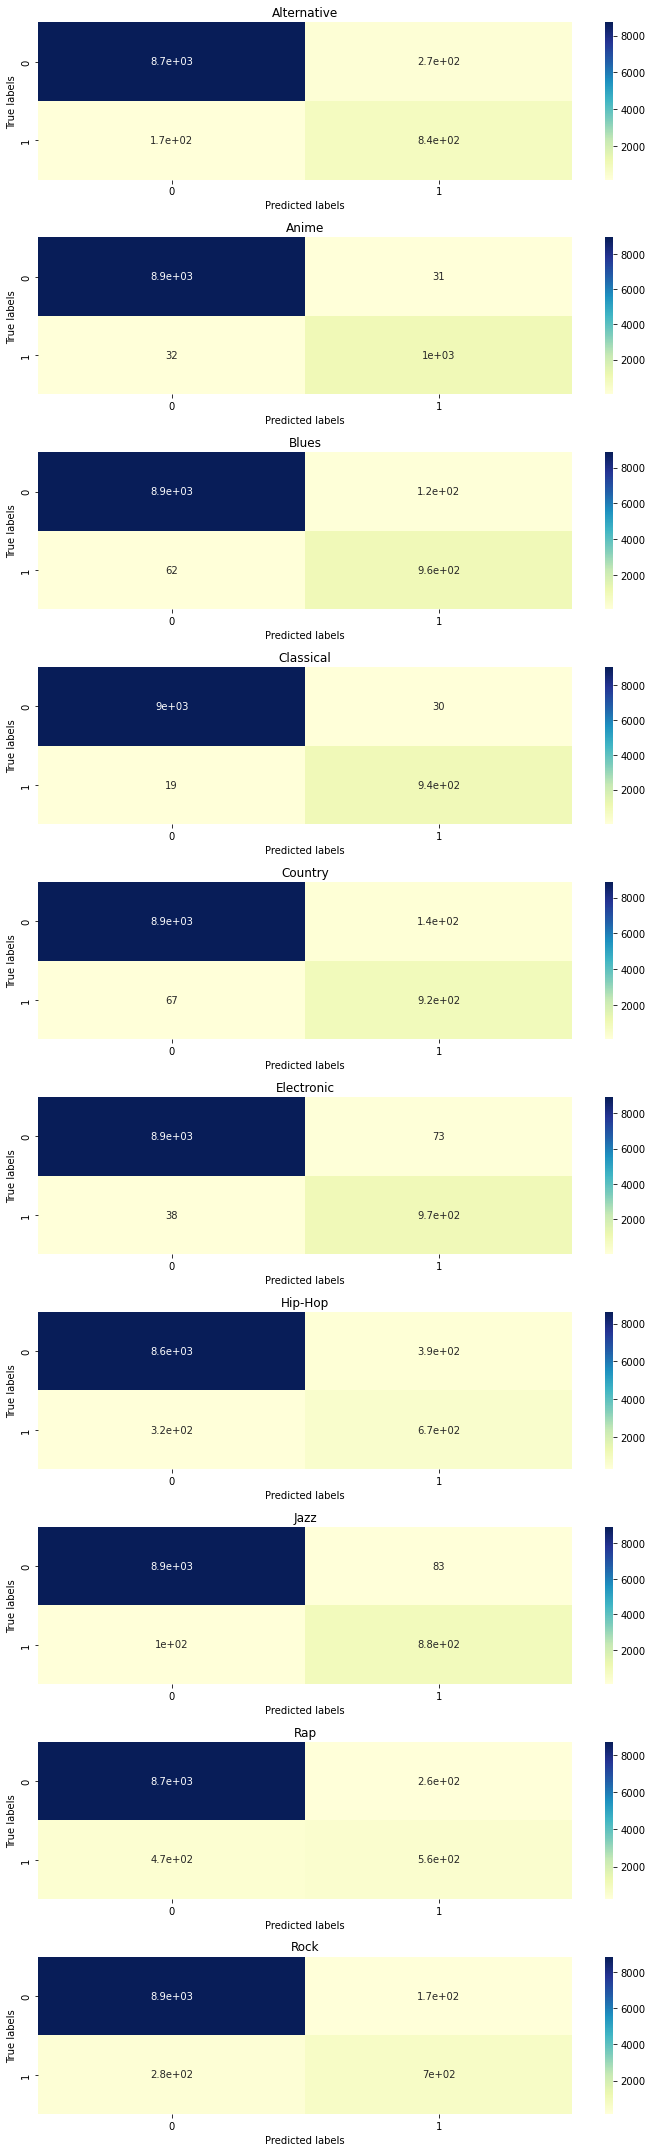

In [165]:
class_labels = mlb.classes_

# Loop through the labels and plot the confusion matrix
fig, axes = plt.subplots(nrows=len(class_labels), figsize=(10, 30))

for i, label in enumerate(class_labels):
    sns.heatmap(cm[i], annot=True, cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(label)
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

plt.tight_layout()

In [140]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# charger les données
X_train, X_test, y_train, y_test = train_test_split(ss.fit_transform(Data.select_dtypes(exclude=['object']).values),  Data['music_genre'].apply(lambda x: [x]), test_size=0.2, random_state=42)

# convertir les étiquettes en un format binaire avec MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
y_train = mlb.inverse_transform(y_train)
y_test = mlb.inverse_transform(y_test)
clf =make_pipeline(StandardScaler(), LogisticRegression())
    #RandomUnderSampler(random_state=42),
                   # LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000))
#print(y_test.shape)
# Initialisation du classifieur binaire
clf = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=1000)
#clf = LogisticRegression()

# Initialisation de OneVsOneClassifier avec le classifieur binaire
ovo_clf = OneVsOneClassifier(clf)

# Entraînement du modèle
ovo_clf.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = ovo_clf.predict(X_test)

# Évaluation des performances du modèle avec la métrique F1-score
accuracy = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [141]:
accuracy

0.8475

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

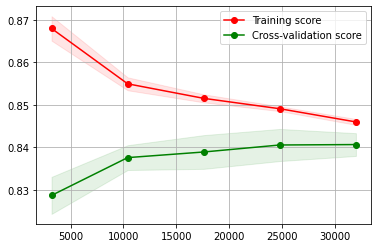

In [144]:

clf = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=1000)

ovo_clf = OneVsOneClassifier(clf)
my_model2 = ovo_clf

plot_learning_curve(my_model2, X_train, y_train,cv=5,n_jobs=4)

In [145]:
from sklearn.metrics import confusion_matrix

# Assuming ypred and ytest are already defined
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 826    2   16    0   24   22   38   13   10   57]
 [   2 1009    4   14    0    1    0    4    0    0]
 [  11   16  948    3    5    2    0   21    0   15]
 [   1   13    2  936    0    0    0    3    0    0]
 [   7    3   16    0  913    0    3    2    4   38]
 [   4    7    4    1    1  962    2   26    1    1]
 [  45    0    0    0    1    2  731    5  208    3]
 [   3    1   32   10    8   44    0  886    0    1]
 [  29    0    0    0   17    0  392    3  563   26]
 [ 128    2   30    1   83    1    6    8   17  701]]


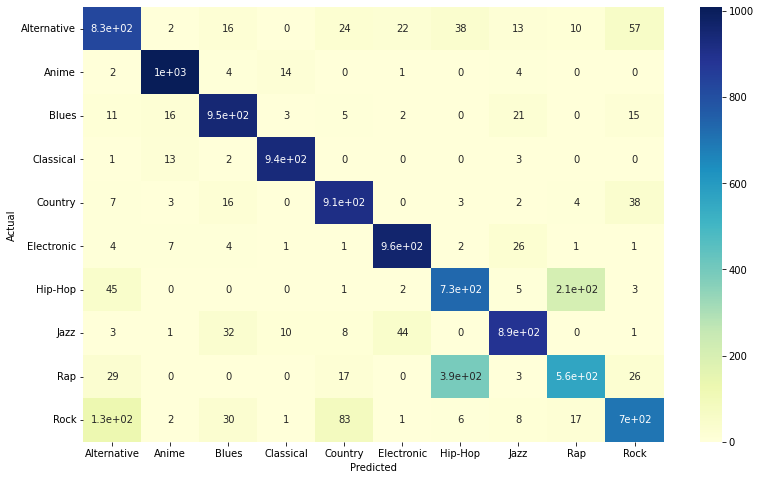

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
labels = mlb.classes_

plt.figure(figsize=(13, 8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()